## Sampling methods

### Generate random number from different distributions

In [3]:
import numpy as np
from scipy import stats
import math
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# generating uniform random variables
unif_list = stats.uniform.rvs(size = 1000)
print(type(unif_list))

<class 'numpy.ndarray'>


In [5]:
norm = stats.norm
norm.pdf(0)

0.3989422804014327

### Inverse Transform sampling
Example: sampling from an exponential distribution.
For $X \sim exp(\lambda)$, the CDF is F(x) = $1-e^{-\lambda x}$. The technique is to to sampling values of $ u = F(x) $ from a uniform distribution, and then work backward to derive value of x for such u. So $x = F^{-1}(u) = - \frac{1}{\lambda} \ln(1-u) $

In [6]:
def inverse_exp_cdf(u, lambda_val = 1):
    return -1/lambda_val * np.log(1-u)

unif_samples = stats.uniform.rvs(size = 1000)
exp_samples = inverse_exp_cdf(unif_samples)

In [7]:
### let's look at the bar chart of the samples
### divide the values into bins using numpy histogram
def plot_samples(samples, dist, bins=100):
#     rang = samples.max() - samples.min()
#     width = rang / bins
#     hist, bin_edges = np.histogram(samples, bins=bins)
#     if bins <= 100:
#         print(hist)
#         print(bin_edges)
    ### actually draw the plot using pyplot bar chart
    fib, ax = plt.subplots()
#     ax.bar(bin_edges[:-1], hist, width=width) # excluding the last element to equate the number of bins
#     plt.xlim(min(bin_edges), max(bin_edges))
    ax.hist(samples, bins=bins, density=True)
    # compare with the plot of the actual distribution itself
    x = np.linspace(samples.min(), samples.max())
    ax.plot(x, dist.pdf(x), color='red')
    plt.show()

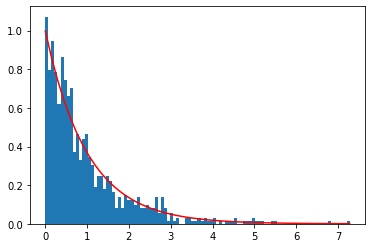

In [8]:
### try ploting with 100 bins
plot_samples(exp_samples, stats.expon)

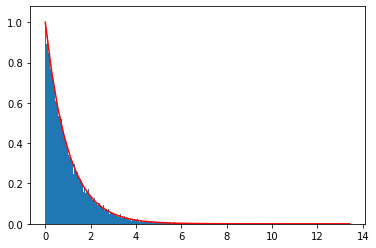

In [9]:
### try ploting with more refined bins => increase samples size too
plot_samples(inverse_exp_cdf(stats.uniform.rvs(size=100000)), stats.expon, bins=1000)

### Rejection sampling
Suppose we want to sample $X$ from the target distribution $\pi(X)$ with PDF $f(x)$
1. Draw $x_{i}$ from the instrumental distribution with PDF $g(x)$
2. Draw $u_{i}$ from $U \sim Unif(0,1)$
3. Consider the ratio $\frac{f(x_{i})}{cg(x_{i})}$:
    - accept $x_{i}$ if $u_{i} \leq \frac{f(x_{i})}{cg(x_{i})}$, in which $c$ is a constant such that $\frac{f(x_{i})}{cg(x_{i})} \in [0, 1]$ over the support of $g$
    - reject otherwise

We see that $u_{i}$ is the chance that $x_{i}$ falls under the curve of $f(x)$, bounded by the curve of $g(x)$

We'll try to sample from a standard normal distribution, using exponential distribution in the first examples and uniform distribution in the second. Each instrumental distribution comes with a different value of c such that c is the minimum value for $cg$ bounds $f$ over the support.
To find c, we solve for the maximum value of $\frac{f(x)}{g(x)}$.

#1: exponential distribution $f(x) = e^{-\lambda x}$. Find $\max\left(\frac{\frac{1}{\sqrt{2\pi}} e^{\frac{-x^{2}}{2}}}{e^{-\lambda x}}\right)$ using standard calculus, we get $c=\sqrt{\frac{e}{2\pi}}$

#2: uniform distribution. It's easy in this case to solve for c. As we know the peak of normal pdf is at $x=0$, substitute that in the normal pdf we get $f(0) = 0.399$. So $c = 0.399$. Here's the catch, we need to times this by 12 since the support we chose is $[-6, 6]$ while the support of standard uniform distribution is only $[0,1]$

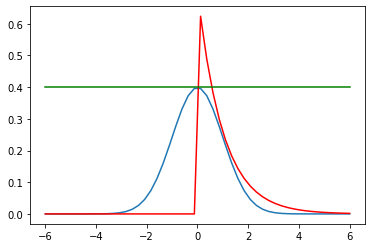

In [144]:
x = np.linspace(-6, 6) # so we pick the support of [-6, 6]
plt.plot(x, stats.norm.pdf(x))
plt.plot(x, 0.705*stats.expon.pdf(x), color='red')
plt.plot(x, 0.399*12*stats.uniform.pdf(x, loc=-6, scale=12), color='green')

In [189]:
def rejection_sampling(target_dist, size, instrumental_dist, c, support=[0,1], instrumental_samples=None, mirror=1):
    '''
        instrumental_samples, if any, must be a generator
    '''
    target_samples = np.array([])
    loc = support[0]
    scale = support[1] - loc
    instrumental_gen = lambda: next(instrumental_samples) if instrumental_samples \
                        else instrumental_dist.rvs(size = 1, loc=loc, scale=scale)[0]
    while len(target_samples) < size:
        x = instrumental_gen()
        u = stats.uniform.rvs(size = 1)
        if u <= target_dist.pdf(x)/(c*instrumental_dist.pdf(x, loc=loc, scale=scale)):
            reflect = stats.uniform.rvs(size = 1)
            if reflect < 0.5:
                x = x*mirror
            target_samples = np.append(target_samples, x)
    return target_samples

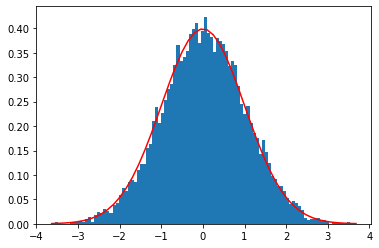

In [199]:
# examples 1: using uniform distribution as the instrumental distribution
norm_samples = rejection_sampling(stats.norm, 10000, stats.uniform, 0.399*8, support=[-4, 4])
plot_samples(norm_samples, stats.norm, bins = 100)

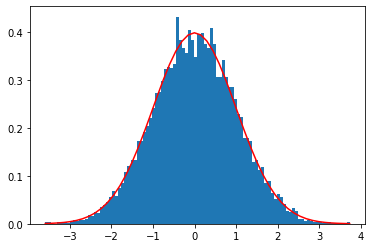

In [200]:
# examples 2: using exponential distribution as the instrumental distribution
c = math.sqrt(math.e/(2*math.pi)) # use calculus to find the maximum value of f/g
norm_samples = rejection_sampling(stats.norm, 10000, stats.expon, c, mirror=-1)
plot_samples(norm_samples, stats.norm, bins = 100)

## Monte Carlo Integration

Examples

#1: $\int_{0}^{\pi} \sin{x} dx $, which has analytical solution = 2. Rewrite the integration as $\int_{0}^{\pi} \sin{x} dx = \pi\int_{0}^{\pi} \frac{1}{\pi}\sin{x} dx = \pi\mathbb{E}[\sin X]$, where $X \sim U(1, \pi) $

#2: $\int_{-\infty}^{\infty} e^{-x^{2}}dx$, does not have any analytical solution for the indefinite integral. However, the above integral does have a close-formed solution of $\sqrt{\pi}$. Rewrite the integration as
\begin{equation}
\int_{-\infty}^{\infty} e^{-x^{2}}dx = \sqrt{2\pi}\int_{-\infty}^{\infty} e^{\frac{-x^{2}}{2}} \frac{1}{\sqrt{2\pi}} e^{\frac{-x^{2}}{2}} dx = \sqrt{2\pi} \mathbb{E}[e^{\frac{-x^{2}}{2}}]
\end{equation}

In [299]:
def monte_carlo_integration(inner_func, outer_func, dist, sample_size = 1000):
    '''
        func: take np.array as input and return array of point-wise values
    '''
    samples = dist.rvs(size = sample_size)
    func_values = inner_func(samples)
    sample_mean = np.mean(func_values)
    estimated_val = outer_func(sample_mean)
    sample_std = np.std(outer_func(func_values))/np.sqrt(sample_size)
    return estimated_val, sample_std

In [300]:
# example 1: integrate sinxdx
sin_estimates = []
sin_std = []

np.random.seed(0)
for size in range(1000, 50000, 1000):
    m, s = monte_carlo_integration(np.sin, lambda m: np.pi*m, stats.uniform(loc=0, scale=math.pi), sample_size = size)
    sin_estimates.append(m)
    sin_std.append(s)

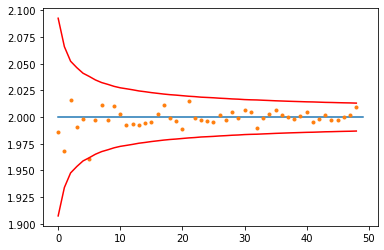

In [301]:
# plot the estimates with respect to samples size and compare with exact close-formed solution (2)
plt.plot([2] * 50)
plt.plot(sin_estimates, '.')
plt.plot(2 + np.array(sin_std) * 3, 'r')
plt.plot(2 - np.array(sin_std) * 3, 'r')
plt.show()

In [297]:
# example 2: integrate e^(-x^2)

f_estimates = []
f_std = []

inner_func = lambda x: np.exp(-x**2/2)
outer_func = lambda m: np.sqrt(2*math.pi) * m
np.random.seed(0)
for size in range(1000, 50000, 1000):
    m, s = monte_carlo_integration(inner_func, outer_func, stats.norm(), sample_size = size)
    f_estimates.append(m)
    f_std.append(s)

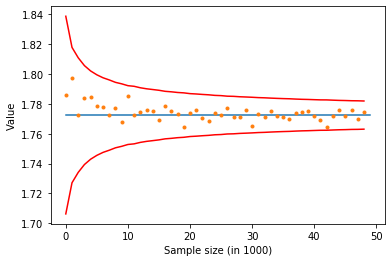

In [298]:
# visualize the estimates, compared to exact solution
exact_sol = np.sqrt(np.pi)
plt.plot([exact_sol] * 50)
plt.plot(f_estimates, '.')
plt.plot(exact_sol + np.array(f_std)*3, 'r')
plt.plot(exact_sol - np.array(f_std)*3, 'r')
plt.xlabel('Sample size (in 1000)')
plt.ylabel('Value')
plt.show()

## Pricing options with Monte Carlo

In [227]:
class OptionsPricer(object):
    def __init__(self, r, sigma, S0, K, T):
        self.r = r
        self.sigma = sigma
        self.S0 = S0
        self.K = K
        self.T = T
        
    def price(self):
        # child classes need to implement this based on their pricing method
        pass

In [258]:
class MonteCarloPricer(OptionsPricer):
    def price(self, sample_size = 1000): # for simplicity, price at t = 0
        Z = stats.norm.rvs(size = sample_size)
        S_Ts = self.S0 * np.exp((self.r - self.sigma**2 / 2) * self.T + self.sigma * np.sqrt(self.T) * Z)
        payoff = np.maximum(S_Ts - self.K, 0)
        discounted_price = np.exp( - self.r * self.T) * payoff
        return np.mean(discounted_price), np.std(discounted_price)/np.sqrt(sample_size)

In [272]:
# example: risk free rate = 0.1, S_0 = 100, sigma = 0.3, strike = 110, T = 1
monteCarloPricer = MonteCarloPricer(0.1, 0.3, 100, 110, 1)
print(monteCarloPricer.price(sample_size = 50000))

(12.076227484348388, 0.09409575587219703)


In [285]:
class BlackScholesPricer(OptionsPricer):
    def price(self, t=0): # for simplicity, price at t = 0
        d1 = self.d1(t)
        d2 = self.d2(t, d1)
        return self.S0 * stats.norm.cdf(d1) - self.K*np.exp(- self.r * self.T)*stats.norm.cdf(d2)
    
    def d1(self, t):
        return (np.log(self.S0 / self.K) + (self.r + self.sigma**2 / 2)*(self.T-t)) \
                / (self.sigma * np.sqrt(self.T - t))
    
    def d2(self, t, d1=None):
        if not d1:
            d1 = self.d1(t)
        return d1 - self.sigma * np.sqrt(self.T - t)

In [288]:
# analytically solve for price using Black Scholes 
blackScholesPricer = BlackScholesPricer(0.1, 0.3, 100, 110, 1)
analytical_price = blackScholesPricer.price()
print(analytical_price)

12.131028958035898


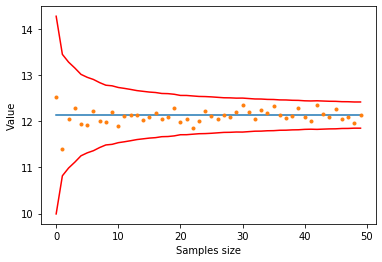

In [289]:
# Compare Monte Carlo simulation with exact solution
mcall_estimated = []
mcall_std = []

for size in range (1000, 50001, 1000):
    m, s = monteCarloPricer.price(sample_size = size)
    mcall_estimated.append(m)
    mcall_std.append(s)
    
plt.plot([analytical_price] * 50)
plt.plot(mcall_estimated, '.')
plt.plot(analytical_price + 3*np.array(mcall_std), 'r')
plt.plot(analytical_price - 3*np.array(mcall_std), 'r')
plt.xlabel('Samples size')
plt.ylabel('Value')
plt.show()